In [285]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
np.random.seed(1337)

In [286]:
# load up the augmented processed GME data
processed_gme_data = pd.read_csv('GME_augmented_processed.csv')
processed_gme_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,LMA,ADX,up,Score,Sentiment
0,2021-02-17,49.770000,51.189999,44.560001,45.939999,45.939999,9186800.0,45.962590,110.887913,78.886475,26.642816,0,-0.173827,-1
1,2021-02-17,49.752222,51.157777,44.505695,45.867082,45.867082,9186800.0,45.953698,110.590784,78.899723,26.625878,0,-0.173827,-1
2,2021-02-17,49.734445,51.125555,44.451390,45.794166,45.794166,9186800.0,45.944800,110.295705,78.912937,26.608974,0,-0.173827,-1
3,2021-02-17,49.716667,51.093332,44.397084,45.721249,45.721249,9186800.0,45.935898,110.002673,78.926115,26.592103,0,-0.173827,-1
4,2021-02-17,49.698889,51.061110,44.342779,45.648332,45.648332,9186800.0,45.926990,109.711690,78.939260,26.575264,0,-0.173827,-1


# Preprocessing

First thing to do is to process the data for the LSTM. We'll have to create windows of data to feed into the network.

need 'lag obeservations': https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [287]:
# dummy example
series = np.array([1,2,3,4,5,6,7,8,9,10])
n_input = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=1)
print(len(generator))
# for i in range(len(generator)):
print(generator) 
for i in range(len(generator)):
    x, y = generator[i]
    print('%s => %s' % (x, y))

8
[[1 2]] => [3]
[[2 3]] => [4]
[[3 4]] => [5]
[[4 5]] => [6]
[[5 6]] => [7]
[[6 7]] => [8]
[[7 8]] => [9]
[[8 9]] => [10]


In [288]:
# data is for 109 days
print(len(processed_gme_data)/72)

# get the split point
split_point = int(len(processed_gme_data)*0.7)
print(split_point)

# create a list of start of day indices to find the closest start of day index
start_of_day_indices = [i for i in range(0, len(processed_gme_data), 72)]

# find the start of day index that's closest to the split point
min_dist = math.inf
split_index = None
for start_of_day_index in start_of_day_indices:
    if abs(split_point-start_of_day_index) < min_dist:
        min_dist = abs(split_point-start_of_day_index)
        split_index = start_of_day_index
# print(f'{split_index} represents day {index_to_use/72}')

109.0
5493


So, training data will be using data from all days up to the 76th day (exclusive). In other words, training data uses 75 "full" days worth of data. Testing will use the rest of the data starting from the 76th day and onwards

In [289]:
# define a window size for the length parameter (to use for TimeseriesGenerator later)
window_size = 2

# separate the data to training and testing (approximately 70/30)
training = processed_gme_data[:split_index]
# offset by window_size since time series training will use input of window_size rows with output of the first row
testing = processed_gme_data[split_index - window_size:]

# separate each data group into data and labels
training_data = training.loc[:, 'Open':'up']
# training_data = training.loc[:, 'Open':'ADX']
# training_labels = training.loc[:, 'up']

testing_data = testing.loc[:, 'Open':'up']
# testing_data = testing.loc[:, 'Open':'ADX']
# testing_labels = testing.loc[:, 'up']

In [290]:
training_data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,LMA,ADX,up
0,49.770000,51.189999,44.560001,45.939999,45.939999,9186800.0,45.962590,110.887913,78.886475,26.642816,0
1,49.752222,51.157777,44.505695,45.867082,45.867082,9186800.0,45.953698,110.590784,78.899723,26.625878,0
2,49.734445,51.125555,44.451390,45.794166,45.794166,9186800.0,45.944800,110.295705,78.912937,26.608974,0
3,49.716667,51.093332,44.397084,45.721249,45.721249,9186800.0,45.935898,110.002673,78.926115,26.592103,0
4,49.698889,51.061110,44.342779,45.648332,45.648332,9186800.0,45.926990,109.711690,78.939260,26.575264,0


In [291]:
# normalize training/testing data using standardscaler
# this also converts the data into numpy arrays (necessary for TimeseriesGenerator)
data_scaler = StandardScaler()
normalized_training_data = data_scaler.fit_transform(training_data)
# training_data_scaler = StandardScaler()
# training_data_scaler = training_data_scaler.fit(training_data)
# normalized_training_data = training_data_scaler.transform(training_data)
# normalized_training_data

# testing_data_scaler = StandardScaler()
# testing_data_scaler = testing_data_scaler.fit(testing_data)
# normalized_testing_data = testing_data_scaler.transform(testing_data)
normalized_testing_data = data_scaler.transform(testing_data)

In [292]:
# identify the label columns
normalized_training_labels = normalized_training_data[:, 10]
normalized_testing_labels = normalized_testing_data[:, 10]
print(normalized_training_labels)
print(normalized_testing_labels)
# training_labels

[-0.97402153 -0.97402153 -0.97402153 ...  1.02667135  1.02667135
  1.02667135]
[1.02667135 1.02667135 1.02667135 ... 1.02667135 1.02667135 1.02667135]


In [293]:
# testing_ts_generator

In [294]:
type(normalized_testing_data)

numpy.ndarray

In [295]:
# convert dataframe slices to numpy arrays for the timeseries generator
# training_data = np.array(training_data)
# training_labels = np.array(training_labels)
# testing_data = np.array(testing_data)
# testing_labels = np.array(testing_labels)

In [296]:
# create timeseries generators for training and testing data/labels
training_ts_generator = TimeseriesGenerator(
    data=normalized_training_data,
    targets=normalized_training_labels,
#     targets=training_labels,
    length=window_size,
    batch_size=1
)

testing_ts_generator = TimeseriesGenerator(
    data=normalized_testing_data,
    targets=normalized_testing_labels,
#     targets=testing_labels,
    length=window_size,
    batch_size=1
)

In [297]:
# processed_gme_data.head()

In [298]:
# just an example to see what output is
for i in range(len(training_ts_generator)):
    x, y = training_ts_generator[i]
    print('%s => %s' % (x, y))
    break

[[[-2.37120045 -2.40507799 -2.3988217  -2.45805618 -2.45805618
   -0.4053415  -1.059327   -1.01771832 -2.04087564  0.81276943
   -0.97402153]
  [-2.37154838 -2.40565526 -2.39996389 -2.45948248 -2.45948248
   -0.4053415  -1.06037428 -1.02443606 -2.04048903  0.81077442
   -0.97402153]]] => [-0.97402153]


In [299]:
# just an example to see what output is
for i in range(len(testing_ts_generator)):
    x, y = testing_ts_generator[i]
    print('%s => %s' % (x, y))
    break

[[[ 1.70303493  1.72150508  2.02598938  2.10332388  2.10332388
   -0.6397665   1.3803383   1.43456503  1.17756286  1.3348354
    1.02667135]
  [ 1.70357314  1.72573509  2.02874408  2.11192245  2.11192245
   -0.6397665   1.38802248  1.43679133  1.17929748  1.33863748
    1.02667135]]] => [1.02667135]


# LSTM

In [300]:
# normalized_testing_data.shape
# training_ts_generator.shape

In [301]:
# define an LSTM for the normalized training data
training_model = Sequential()
# input_shape for each data input is window_size x number of features (column) in training_data
training_model.add(LSTM(64, activation='sigmoid', input_shape=(window_size, 11), return_sequences=True))
training_model.add(LSTM(96, activation='sigmoid', return_sequences=False))
training_model.add(Dropout(0.2))

# output either standardized 0 or 1
training_model.add(Dense(1))

training_model.compile(optimizer='SGD', loss='mse')
training_model.summary()


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 2, 64)             19456     
_________________________________________________________________
lstm_45 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_22 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 97        
Total params: 81,377
Trainable params: 81,377
Non-trainable params: 0
_________________________________________________________________


In [302]:
%%time
history_train = training_model.fit(training_ts_generator, validation_data=testing_ts_generator, epochs=10)

Epoch 1/10
5470/5470 [==============================] - 29s 4ms/step - loss: 0.9064 - val_loss: 0.0475
Epoch 2/10
5470/5470 [==============================] - 22s 4ms/step - loss: 0.0938 - val_loss: 0.0303
Epoch 3/10
5470/5470 [==============================] - 30s 5ms/step - loss: 0.0684 - val_loss: 0.0352
Epoch 4/10
5470/5470 [==============================] - 28s 5ms/step - loss: 0.0616 - val_loss: 0.0295
Epoch 5/10
5470/5470 [==============================] - 31s 6ms/step - loss: 0.0563 - val_loss: 0.0383
Epoch 6/10
5470/5470 [==============================] - 29s 5ms/step - loss: 0.0532 - val_loss: 0.0302
Epoch 7/10
5470/5470 [==============================] - 29s 5ms/step - loss: 0.0514 - val_loss: 0.0312
Epoch 8/10
5470/5470 [==============================] - 29s 5ms/step - loss: 0.0541 - val_loss: 0.0300
Epoch 9/10
5470/5470 [==============================] - 21s 4ms/step - loss: 0.0413 - val_loss: 0.0291
Epoch 10/10
5470/5470 [==============================] - 30s 6ms/step - l

In [303]:
history_train.history

{'loss': [0.5626396536827087,
  0.07855729758739471,
  0.062411241233348846,
  0.05573398619890213,
  0.05248274654150009,
  0.05013328045606613,
  0.04878585413098335,
  0.048257406800985336,
  0.04595864564180374,
  0.04630189761519432],
 'val_loss': [0.04745972156524658,
  0.03030472621321678,
  0.03520014137029648,
  0.02949136309325695,
  0.03825923800468445,
  0.0301724374294281,
  0.03115302324295044,
  0.030026188120245934,
  0.02905491553246975,
  0.029309706762433052]}

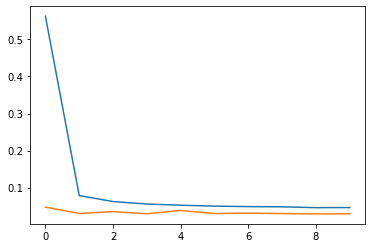

In [304]:
# history_train.history
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.show()

In [305]:
training_results = training_model.evaluate(training_ts_generator)
testing_results = training_model.evaluate(testing_ts_generator)

2376/2376 [==============================] - 5s 2ms/step - loss: 0.0293


In [306]:
# results
prediction_results = training_model.predict(testing_ts_generator)

In [307]:
prediction_results

array([[1.0091802 ],
       [1.0092525 ],
       [1.0091311 ],
       ...,
       [0.98138934],
       [0.9814202 ],
       [0.98145086]], dtype=float32)

In [308]:
correctly_shaped_prediction_results = np.repeat(prediction_results, 11, axis=-1)
correctly_shaped_prediction_results

array([[1.0091802 , 1.0091802 , 1.0091802 , ..., 1.0091802 , 1.0091802 ,
        1.0091802 ],
       [1.0092525 , 1.0092525 , 1.0092525 , ..., 1.0092525 , 1.0092525 ,
        1.0092525 ],
       [1.0091311 , 1.0091311 , 1.0091311 , ..., 1.0091311 , 1.0091311 ,
        1.0091311 ],
       ...,
       [0.98138934, 0.98138934, 0.98138934, ..., 0.98138934, 0.98138934,
        0.98138934],
       [0.9814202 , 0.9814202 , 0.9814202 , ..., 0.9814202 , 0.9814202 ,
        0.9814202 ],
       [0.98145086, 0.98145086, 0.98145086, ..., 0.98145086, 0.98145086,
        0.98145086]], dtype=float32)

In [309]:
inverse_transform_results = data_scaler.inverse_transform(correctly_shaped_prediction_results)

In [310]:
binary_results = inverse_transform_results[:, 10]

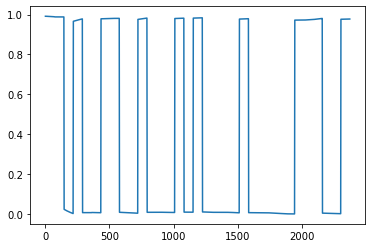

In [311]:
plt.plot(binary_results)
plt.show()

In [312]:
predicted_testing_labels = []
for label in binary_results:
    if label > 0.9:
        predicted_testing_labels.append(1)
    else:
        predicted_testing_labels.append(0)

In [313]:
# predicted_testing_labels

In [314]:
actual_testing_labels = list(testing_data['up'])
# actual_testing_labels

In [315]:
correct_count = 0
for predicted_label, actual_label in zip(predicted_testing_labels, actual_testing_labels):
    if predicted_label == actual_label:
        correct_count += 1
print(correct_count)
print(len(actual_testing_labels))

# print out correct ratio
print(correct_count/len(actual_testing_labels))

2368
2378
0.9957947855340622


# BELOW USED FOR TESTING. RUN OPTIONALLY (takes excessively long time [4-5 hours])

# testing different values of time step for accuracy

In [281]:
window_accuracies = []
for window in range (1,11):
    training_ts_generator = TimeseriesGenerator(
        data=normalized_training_data,
        targets=normalized_training_labels,
    #     targets=training_labels,
        length=window,
        batch_size=1
    )

    testing_ts_generator = TimeseriesGenerator(
        data=normalized_testing_data,
        targets=normalized_testing_labels,
    #     targets=testing_labels,
        length=window,
        batch_size=1
    ) 
    training_model = Sequential()
    # input_shape for each data input is window_size x number of features (column) in training_data
    training_model.add(LSTM(64, activation='sigmoid', input_shape=(window, 11), return_sequences=True))
    training_model.add(LSTM(96, activation='sigmoid', return_sequences=False))
    training_model.add(Dropout(0.2))

    # output either standardized 0 or 1
    training_model.add(Dense(1))

    training_model.compile(optimizer='SGD', loss='mse')
    training_model.summary()
    
    history_train = training_model.fit(training_ts_generator, validation_data=testing_ts_generator, epochs=5)
    
    training_results = training_model.evaluate(training_ts_generator)
    testing_results = training_model.evaluate(testing_ts_generator)
    
    prediction_results = training_model.predict(testing_ts_generator)
    
    correctly_shaped_prediction_results = np.repeat(prediction_results, 11, axis=-1)

    inverse_transform_results = data_scaler.inverse_transform(correctly_shaped_prediction_results)
    
    binary_results = inverse_transform_results[:, 10]
    
    predicted_testing_labels = []
    for label in binary_results:
        if label > 0.9:
            predicted_testing_labels.append(1)
        else:
            predicted_testing_labels.append(0)
            
    correct_count = 0
    for predicted_label, actual_label in zip(predicted_testing_labels, actual_testing_labels):
        if predicted_label == actual_label:
            correct_count += 1
    print(correct_count)
    print(len(actual_testing_labels))

    # print out correct ratio
    current_accuracy = correct_count/len(actual_testing_labels)
    print(current_accuracy)
    window_accuracies.append(current_accuracy)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 64)             19456     
_________________________________________________________________
lstm_25 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_12 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 97        
Total params: 81,377
Trainable params: 81,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5471/5471 [==============================] - 22s 3ms/step - loss: 1.0090 - val_loss: 0.0892
Epoch 2/5
5471/5471 [==============================] - 16s 3ms/step - loss: 0.1102 - val_loss: 0.0332
Epoch 3/5
5471/5471 [======================

5466/5466 [==============================] - 48s 8ms/step - loss: 0.7950 - val_loss: 0.0394
Epoch 2/5
5466/5466 [==============================] - 50s 9ms/step - loss: 0.0836 - val_loss: 0.0346
Epoch 3/5
5466/5466 [==============================] - 69s 13ms/step - loss: 0.0572 - val_loss: 0.0798
Epoch 4/5
5466/5466 [==============================] - 51s 9ms/step - loss: 0.0553 - val_loss: 0.0327
Epoch 5/5
2442/2442 [==============================] - 6s 2ms/step - loss: 0.0323
2378
2448
0.9714052287581699
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 7, 64)             19456     
_________________________________________________________________
lstm_37 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_18 (Dropout)         (None, 96)                0         
_____

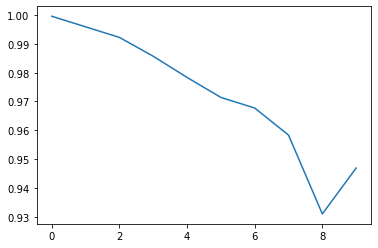

In [283]:
plt.plot(window_accuracies)
plt.show()

From the above plot, it appears that the more lagged observations are given, the lower the accuracy becomes. Although there is a shift in trend, based on the amount of time it takes to run the network (about 8 minutes per network with 5 epochs), this will be an area for further improvment

If we extend to 72 for the time steps size, the accuracy goes all the way to approximately 50%. Two such networks are saved in the keras_models folder. One represents a network that uses the sentiment data, while the other does not use the sentiment data.

In [284]:
window_accuracies

[0.9995915032679739,
 0.9959150326797386,
 0.9922385620915033,
 0.985702614379085,
 0.9783496732026143,
 0.9714052287581699,
 0.9677287581699346,
 0.9583333333333334,
 0.9309640522875817,
 0.9468954248366013]

# save the model so far

In [278]:
# training_model.save('./keras_models/lstm_72_sequence_20_epoch')

INFO:tensorflow:Assets written to: ./keras_models/lstm_72_sequence_20_epoch/assets


# Cross Validation

In [443]:
activation_funcs = ['relu', 'sigmoid', 'softmax']
node_values = [val for val in range(32, 129, 32)]
drop_values = [0.2, 0.3, 0.4, 0.5]
node_values

[32, 64, 96, 128]

In [444]:
# %%time
# history_train = training_model.fit(training_ts_generator, epochs=5)

In [445]:
# training_results = training_model.evaluate(training_ts_generator)
# testing_results = training_model.evaluate(testing_ts_generator)

In [446]:
# training_results
history_train.history

{'loss': [0.5724188089370728,
  0.0920354574918747,
  0.07440289109945297,
  0.06676856428384781,
  0.06256063282489777,
  0.0596199706196785,
  0.056295670568943024,
  0.05643153190612793,
  0.0549185648560524,
  0.05512009561061859]}

In [449]:
# runs for around 4 hours! avoid running if possible!!!!

# define min_loss
min_loss = math.inf

# define best hyper params to use
best_func = None
best_first_hidden_nodes = None
best_second_hidden_nodes = None
best_dropout = None

for activation_func in activation_funcs:
    for i in range(len(node_values)):
        for j in range(len(node_values)):
            for drop_value in drop_values:
                
                # define an LSTM for the normalized training data
                cross_valid_model = Sequential()
                # input_shape for each data input is window_size x number of features (column) in training_data
                cross_valid_model.add(
                    LSTM(
                        node_values[i],
                        activation=activation_func,
                        input_shape=(window_size, 11),
                        return_sequences=True
                    )
                )
                cross_valid_model.add(
                    LSTM(
                        node_values[j],
                        activation=activation_func,
                        return_sequences=False
                    )
                )
                cross_valid_model.add(Dropout(drop_value))

                # output either standardized 0 or 1
                cross_valid_model.add(Dense(1))

                # leaving optimizer and loss funcs as-is
                cross_valid_model.compile(optimizer='SGD', loss='mse')
                
                # fit data to the cross_validation model
                cross_valid_model.fit(training_ts_generator, epochs=5)
                
                # training/testing loss values
                cross_valid_train_loss = cross_valid_model.evaluate(training_ts_generator)
                cross_valid_test_loss = cross_valid_model.evaluate(testing_ts_generator)
                
                if cross_valid_test_loss < min_loss:
                    best_func = activation_func
                    best_first_hidden_nodes = node_values[i]
                    best_second_hidden_nodes = node_values[j]
                    best_dropout = drop_value
                    min_loss = cross_valid_test_loss
                    print(f'{best_func}, {best_first_hidden_nodes}, {best_second_hidden_nodes}, {best_dropout}')
                    print(min_loss)
                
# cross_valid_model.summary()


Epoch 1/5
5470/5470 [==============================] - 20s 3ms/step - loss: 0.4397
Epoch 2/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0684: 
Epoch 3/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0654
Epoch 4/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0574
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.0337
relu, 32, 32, 0.2
0.033741582185029984
Epoch 1/5
5470/5470 [==============================] - 19s 3ms/step - loss: 0.3524
Epoch 2/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0771
Epoch 3/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0767
Epoch 4/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0652
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.0360
Epoch 1/5
5470/5470 [==============================] - 19s 3ms/step - loss: 0.3342
Epoch 2/5
5470/5470 [===========================

2376/2376 [==============================] - 3s 1ms/step - loss: 0.0458
Epoch 1/5
5470/5470 [==============================] - 20s 3ms/step - loss: 0.3702
Epoch 2/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0568
Epoch 3/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0484
Epoch 4/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0465
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.0382
Epoch 1/5
5470/5470 [==============================] - 20s 3ms/step - loss: 0.3512
Epoch 2/5
5470/5470 [==============================] - 17s 3ms/step - loss: 0.0554
Epoch 3/5
5470/5470 [==============================] - 17s 3ms/step - loss: 0.0530
Epoch 4/5
5470/5470 [==============================] - 16s 3ms/step - loss: 0.0567
Epoch 5/5
2376/2376 [==============================] - 4s 2ms/step - loss: 0.0358
Epoch 1/5
5470/5470 [==============================] - 22s 3ms/step - loss: 0.4051
Epoch 2/5
5470/54

5470/5470 [==============================] - 20s 3ms/step - loss: 0.3252
Epoch 2/5
5470/5470 [==============================] - 22s 4ms/step - loss: 0.0617
Epoch 3/5
5470/5470 [==============================] - 21s 4ms/step - loss: 0.0666
Epoch 4/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0665
Epoch 5/5
2376/2376 [==============================] - 4s 2ms/step - loss: 0.0347
Epoch 1/5
5470/5470 [==============================] - 22s 3ms/step - loss: 0.3412
Epoch 2/5
5470/5470 [==============================] - 19s 3ms/step - loss: 0.0639
Epoch 3/5
5470/5470 [==============================] - 19s 3ms/step - loss: 0.0670
Epoch 4/5
5470/5470 [==============================] - 19s 3ms/step - loss: 0.0726
Epoch 5/5
2376/2376 [==============================] - 4s 2ms/step - loss: 0.0524A: 0s - l
Epoch 1/5
5470/5470 [==============================] - 23s 4ms/step - loss: 0.3457
Epoch 2/5
5470/5470 [==============================] - 19s 4ms/step - loss: 0.0471: 0s - l

2376/2376 [==============================] - 3s 1ms/step - loss: 0.0317
Epoch 1/5
5470/5470 [==============================] - 18s 3ms/step - loss: 1.0510
Epoch 2/5
5470/5470 [==============================] - 15s 3ms/step - loss: 0.1847
Epoch 3/5
5470/5470 [==============================] - 15s 3ms/step - loss: 0.1260
Epoch 4/5
5470/5470 [==============================] - 15s 3ms/step - loss: 0.0989
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.0443
Epoch 1/5
5470/5470 [==============================] - 20s 3ms/step - loss: 0.9496
Epoch 2/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0906
Epoch 3/5
5470/5470 [==============================] - 17s 3ms/step - loss: 0.0728
Epoch 4/5
5470/5470 [==============================] - 17s 3ms/step - loss: 0.0740
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.0292
sigmoid, 64, 96, 0.2
0.02916168048977852
Epoch 1/5
5470/5470 [==============================] - 20s 

2376/2376 [==============================] - 3s 1ms/step - loss: 0.0374
Epoch 1/5
5470/5470 [==============================] - 21s 3ms/step - loss: 0.8618
Epoch 2/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0878: 1s - l
Epoch 3/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0657
Epoch 4/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0623
Epoch 5/5
2376/2376 [==============================] - 4s 2ms/step - loss: 0.0322A: 0s - 
Epoch 1/5
5470/5470 [==============================] - 22s 3ms/step - loss: 0.9111
Epoch 2/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0998
Epoch 3/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0831
Epoch 4/5
5470/5470 [==============================] - 18s 3ms/step - loss: 0.0633
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.0321
Epoch 1/5
5470/5470 [==============================] - 22s 3ms/step - loss: 1.0340
E

2376/2376 [==============================] - 3s 1ms/step - loss: 0.9854
Epoch 1/5
5470/5470 [==============================] - 23s 3ms/step - loss: 1.0124
Epoch 2/5
5470/5470 [==============================] - 19s 4ms/step - loss: 1.0111
Epoch 3/5
5470/5470 [==============================] - 19s 3ms/step - loss: 1.0091
Epoch 4/5
5470/5470 [==============================] - 16s 3ms/step - loss: 1.0170
Epoch 5/5
2376/2376 [==============================] - 3s 1ms/step - loss: 0.9638
Epoch 1/5
5470/5470 [==============================] - 27s 3ms/step - loss: 1.0123
Epoch 2/5
5470/5470 [==============================] - 16s 3ms/step - loss: 1.0151
Epoch 3/5
5470/5470 [==============================] - 17s 3ms/step - loss: 1.0091
Epoch 4/5
5470/5470 [==============================] - 18s 3ms/step - loss: 1.0078
Epoch 5/5
2376/2376 [==============================] - 5s 2ms/step - loss: 0.9562
Epoch 1/5
5470/5470 [==============================] - 23s 3ms/step - loss: 1.0092: 2s
Epoch 2/5
547

5470/5470 [==============================] - 23s 4ms/step - loss: 1.0132
Epoch 2/5
5470/5470 [==============================] - 23s 4ms/step - loss: 1.0124
Epoch 3/5
5470/5470 [==============================] - 19s 3ms/step - loss: 1.0101
Epoch 4/5
5470/5470 [==============================] - 19s 3ms/step - loss: 1.0108
Epoch 5/5
2376/2376 [==============================] - 5s 2ms/step - loss: 1.0237
Epoch 1/5
5470/5470 [==============================] - 26s 4ms/step - loss: 1.0077
Epoch 2/5
5470/5470 [==============================] - 21s 4ms/step - loss: 1.0080
Epoch 3/5
5470/5470 [==============================] - 22s 4ms/step - loss: 1.0135
Epoch 4/5
5470/5470 [==============================] - 22s 4ms/step - loss: 1.0090
Epoch 5/5
2376/2376 [==============================] - 4s 2ms/step - loss: 0.9847
Epoch 1/5
5470/5470 [==============================] - 23s 4ms/step - loss: 1.0105
Epoch 2/5
5470/5470 [==============================] - 19s 3ms/step - loss: 1.0109
Epoch 3/5
5470/5

In [450]:
print(best_func)
print(best_first_hidden_nodes)
print(best_second_hidden_nodes)
print(best_dropout)
print(min_loss)

sigmoid
64
96
0.2
0.02916168048977852
